In [ ]:
pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 26.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dmba import classificationSummary

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
df = pd.read_excel('/content/for_machine_learningdf.xlsx')

In [ ]:
df.set_index('customerID', inplace=True)

# Contininuing Tuning Logistic Regression Model that gave best recall score

In [ ]:
X = df.drop(['partner', 'churn'], axis=1)
y = df.churn

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=.1, stratify=y, random_state=0
)

In [ ]:
pipeline = Pipeline([
    ('standardScaling', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=100,
                              penalty='l2', solver='lbfgs'))
])

## Trying to see if changing the penalty term (C parameter) in regularization of parameters will improve performance

In [ ]:
np.linspace(5, 15, 10)

array([ 5.        ,  6.11111111,  7.22222222,  8.33333333,  9.44444444,
       10.55555556, 11.66666667, 12.77777778, 13.88888889, 15.        ])

In [ ]:
param_grid = [
    {'lr__C': np.linspace(5,15,10)}
]

In [ ]:
best_C = GridSearchCV(
    pipeline, param_grid, scoring='recall', cv=5
)

In [ ]:
best_C.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           fit_intercept=False))]),
             param_grid=[{'lr__C': array([ 5.        ,  6.11111111,  7.22222222,  8.33333333,  9.44444444,
       10.55555556, 11.66666667, 12.77777778, 13.88888889, 15.        ])}],
             scoring='recall')

In [ ]:
best_C.best_params_

{'lr__C': 5.0}

In [ ]:
class_names = ['no churn', 'churn']

In [ ]:
classificationSummary(y_valid, best_C.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7188)

         Prediction
  Actual no churn    churn
no churn      244      127
   churn       15      119


# ^New Best Model (same Recall, but slightly better True Negative Rate and Accuracy)

In [ ]:
np.linspace(2.5, 7.5, 10)

array([2.5       , 3.05555556, 3.61111111, 4.16666667, 4.72222222,
       5.27777778, 5.83333333, 6.38888889, 6.94444444, 7.5       ])

In [ ]:
param_grid = [
    {'lr__C': np.linspace(2.5, 7.5, 10)}
]

In [ ]:
best_C_2 = GridSearchCV(
    pipeline, param_grid, scoring='recall', cv=5
)

In [ ]:
best_C_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           fit_intercept=False))]),
             param_grid=[{'lr__C': array([2.5       , 3.05555556, 3.61111111, 4.16666667, 4.72222222,
       5.27777778, 5.83333333, 6.38888889, 6.94444444, 7.5       ])}],
             scoring='recall')

In [ ]:
best_C_2.best_params_

{'lr__C': 3.0555555555555554}

In [ ]:
classificationSummary(y_valid, best_C_2.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7188)

         Prediction
  Actual no churn    churn
no churn      244      127
   churn       15      119


## Nothing worth implementing/changing

In [ ]:
lr_model = best_C

In [ ]:
classificationSummary(y_valid, lr_model.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7188)

         Prediction
  Actual no churn    churn
no churn      244      127
   churn       15      119


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_valid, lr_model.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.94      0.66      0.77       371
           1       0.48      0.89      0.63       134

    accuracy                           0.72       505
   macro avg       0.71      0.77      0.70       505
weighted avg       0.82      0.72      0.74       505



# Attempting to use the RepeatedStratifiedKFold Parameter and can improve any hyperparameters and performance

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
pipeline = Pipeline([
    ('standardScaling', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=100,
                              penalty='l2', solver='lbfgs'))
])

In [ ]:
param_grid = [
    {'lr__C': np.linspace(2.5, 7.5, 10),
     'lr__fit_intercept': [False, True]}
]

In [ ]:
new_model = GridSearchCV(
    pipeline, param_grid, scoring='recall',
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
)

In [ ]:
new_model.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'lr__C': array([2.5       , 3.05555556, 3.61111111, 4.16666667, 4.72222222,
       5.27777778, 5.83333333, 6.38888889, 6.94444444, 7.5       ]),
                          'lr__fit_intercept': [False, True]}],
             scoring='recall')

In [ ]:
new_model.best_params_

{'lr__C': 3.611111111111111, 'lr__fit_intercept': False}

In [ ]:
classificationSummary(y_valid, new_model.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7188)

         Prediction
  Actual no churn    churn
no churn      244      127
   churn       15      119


In [ ]:
pipeline = Pipeline([
    ('standardScaling', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=100,
                              penalty='l2', solver='lbfgs', C=3.6111111 ))
])

## No change

In [ ]:
lr_model = new_model

In [ ]:
param_grid = {
    'standardScaling__with_mean': [True, False],
    'standardScaling__with_std': [True, False]

}

In [ ]:
new_model = GridSearchCV(
    pipeline, param_grid, scoring='recall',
    cv=5
)

In [ ]:
new_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(C=3.6111111,
                                                           class_weight='balanced',
                                                           fit_intercept=False))]),
             param_grid={'standardScaling__with_mean': [True, False],
                         'standardScaling__with_std': [True, False]},
             scoring='recall')

In [ ]:
new_model.best_params_

{'standardScaling__with_mean': True, 'standardScaling__with_std': True}

In [ ]:
lr_model

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'lr__C': array([2.5       , 3.05555556, 3.61111111, 4.16666667, 4.72222222,
       5.27777778, 5.83333333, 6.38888889, 6.94444444, 7.5       ]),
                          'lr__fit_intercept': [False, True]}],
             scoring='recall')

# Interaction Terms and Polynomial Features

In [ ]:
df.head()

,seniorCitizen,partner,dependents,tenure,phoneService,paperlessBilling,monthlyCharges,totalCharges,gender_Male,multipleLines_True,multipleLines_No phone service,internetService_DSL,internetService_Fiber optic,onlineSecurity_True,onlineSecurity_No internet service,onlineBackup_True,onlineBackup_No internet service,deviceProtection_True,deviceProtection_No internet service,techSupport_True,techSupport_No internet service,streamingTV_True,streamingTV_No internet service,streamingMovies_True,streamingMovies_No internet service,contract_One year,contract_Two year,paymentMethod_Credit card (automatic),paymentMethod_Electronic check,paymentMethod_Mailed check,churn
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,1,0,1,29.850000,29.850000,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5575-GNVDE,0,0,0,34,1,0,56.950001,1889.500000,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3668-QPYBK,0,0,0,2,1,1,53.849998,108.150002,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7795-CFOCW,0,0,0,45,0,0,42.299999,1840.750000,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
9237-HQITU,0,0,0,2,1,1,70.699997,151.649994,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
polyFeatures = pd.DataFrame(PolynomialFeatures(degree=2, include_bias=False).fit_transform(
    df[['tenure', 'monthlyCharges', 'totalCharges']]),
    columns=['tenure','monthlyCharges','totalCharges','tenure_squared','tenure_monthlycharges',
             'tenure_totalCharges','monthlyCharges_squared','monthlyCharges_totalCharges',
             'totalCharges_squared'], index=df.index).drop(['tenure','monthlyCharges','totalCharges'],axis=1)
 #tenure, monthlyCharges, totalCharges, tenure**2, tenure*monthlyCharges, tenure*totalCharges, monthlyCharges**2,
   # monthlyCharges*totalCharges, totalCharges**2

In [ ]:
df_PolyFeatures = df.join(polyFeatures, how='inner').sort_index(axis='columns')

In [ ]:
X = df_PolyFeatures.drop(['churn','partner'],axis=1)
y = df_PolyFeatures.churn

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=0
)

In [ ]:
minmax_base = Pipeline([
    ('minmax', MinMaxScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1, random_state=0))
])

In [ ]:
minmax_base.fit(X_train, y_train)

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=0))])

In [ ]:
classificationSummary(y_valid, minmax_base.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7564)

         Prediction
  Actual no churn    churn
no churn      277       94
   churn       29      105


In [ ]:
standard_base = Pipeline([
    ('standard', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1, random_state=0))
])

In [ ]:
standard_base.fit(X_train,y_train)

Pipeline(steps=[('standard', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=0))])

In [ ]:
classificationSummary(y_valid, standard_base.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7604)

         Prediction
  Actual no churn    churn
no churn      277       94
   churn       27      107


## So far adding interaction terms and polynomial seems to make models performance worse.

## Attempting to select variables that don't seem to distinguish well based on response (off of boxplot) and see how performance responds, initially without interactive terms because they just seem to unnecesarily increase complexity.

In [ ]:
X = df.drop(['churn','partner','phoneService','gender_Male','multipleLines_True',
             'multipleLines_No phone service','internetService_Fiber optic',
             'onlineBackup_True','deviceProtection_True','streamingTV_True','streamingMovies_True',
             'paymentMethod_Electronic check'], axis=1)

In [ ]:
y = df.churn

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=0
)

In [ ]:
pipeline = Pipeline([
    ('standardScaling', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000,
                              penalty='l1', solver='liblinear'))
])

In [ ]:
param_grid = {
    'lr__C': np.linspace(2.5, 7.5, 10)
}

In [ ]:
lr_model = GridSearchCV(
    pipeline, param_grid, scoring='recall',
    cv= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
)

In [ ]:
lr_model.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'lr__C': array([2.5       , 3.05555556, 3.61111111, 4.16666667, 4.72222222,
       5.27777778, 5.83333333, 6.38888889, 6.94444444, 7.5       ])},
             scoring='recall')

In [ ]:
lr_model.best_params_

{'lr__C': 3.0555555555555554}

In [ ]:
classificationSummary(y_valid, lr_model.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7446)

         Prediction
  Actual no churn    churn
no churn      266      105
   churn       24      110


## Recall not better. Some of the predictors were still useful (tried multiple different hyperparameters in the gridsearch).

## Attempting to remove variables that don't seem to distinguish well based on response (off of boxplot) and see how performance responds, now with the interactive terms.

In [ ]:
X = df_PolyFeatures.drop(['churn','partner','phoneService','gender_Male','multipleLines_True',
             'multipleLines_No phone service','internetService_Fiber optic',
             'onlineBackup_True','deviceProtection_True','streamingTV_True','streamingMovies_True',
             'paymentMethod_Electronic check'], axis=1)

y= df_PolyFeatures.churn

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=0
)

In [ ]:
lr_model = GridSearchCV(
    pipeline, param_grid, scoring='recall',
    cv= 5
)

In [ ]:
lr_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'lr__C': array([2.5       , 3.05555556, 3.61111111, 4.16666667, 4.72222222,
       5.27777778, 5.83333333, 6.38888889, 6.94444444, 7.5       ])},
             scoring='recall')

In [ ]:
lr_model.best_params_

{'lr__C': 4.722222222222222}

In [ ]:
classificationSummary(y_valid, lr_model.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7545)

         Prediction
  Actual no churn    churn
no churn      274       97
   churn       27      107


## No better performance.

# Feature Selection to reduce dimensionality

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
variable_selection = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0.15
                                            )),
    ('standardScaling', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=100,
                              penalty='l2', solver='lbfgs', C=3.6111111 ))
]).fit(X_train, y_train)

In [ ]:
pd.Series(variable_selection.named_steps['feature_selection'].get_support())

,0
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,True


In [ ]:
pd.concat([pd.Series(X_train.columns),pd.Series(variable_selection.named_steps['feature_selection'].get_support())],axis=1)

,0,1
0,contract_One year,True
1,contract_Two year,True
2,dependents,True
3,deviceProtection_No internet service,True
4,internetService_DSL,True
5,monthlyCharges,True
6,monthlyCharges_squared,True
7,monthlyCharges_totalCharges,True
8,onlineBackup_No internet service,True
9,onlineSecurity_No internet service,True


## Does not seem like a good idea to implement this and remove the seniorCitizen variable because it is reasonable to suspect that a customer being a 'seniorCitizen' or not has an effect on whether a customer stays with a telecommunications provider or not.

# Feature Importance

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_train.columns

Index(['seniorCitizen', 'dependents', 'tenure', 'phoneService',
       'paperlessBilling', 'monthlyCharges', 'totalCharges', 'gender_Male',
       'multipleLines_True', 'multipleLines_No phone service',
       'internetService_DSL', 'internetService_Fiber optic',
       'onlineSecurity_True', 'onlineSecurity_No internet service',
       'onlineBackup_True', 'onlineBackup_No internet service',
       'deviceProtection_True', 'deviceProtection_No internet service',
       'techSupport_True', 'techSupport_No internet service',
       'streamingTV_True', 'streamingTV_No internet service',
       'streamingMovies_True', 'streamingMovies_No internet service',
       'contract_One year', 'contract_Two year',
       'paymentMethod_Credit card (automatic)',
       'paymentMethod_Electronic check', 'paymentMethod_Mailed check'],
      dtype='object')

In [ ]:
dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

In [ ]:
dt.feature_importances_

array([0.02226065, 0.01831884, 0.18994128, 0.        , 0.02266994,
       0.19594368, 0.20713571, 0.02913001, 0.02084175, 0.00218286,
       0.        , 0.1156192 , 0.01465506, 0.        , 0.02207323,
       0.        , 0.01612224, 0.00569272, 0.01183001, 0.0007576 ,
       0.00930586, 0.00623578, 0.01492668, 0.        , 0.01721401,
       0.02032251, 0.00979133, 0.0169731 , 0.01005594])

In [ ]:
pd.DataFrame([(col, coef) for col, coef in zip(X_train.columns, dt.feature_importances_)],
             columns=['feature','importance']).sort_values('importance', ascending=False, ignore_index=True)

,feature,importance
0,totalCharges,0.207136
1,monthlyCharges,0.195944
2,tenure,0.189941
3,internetService_Fiber optic,0.115619
4,gender_Male,0.029130
5,paperlessBilling,0.022670
6,seniorCitizen,0.022261
7,onlineBackup_True,0.022073
8,multipleLines_True,0.020842
9,contract_Two year,0.020323


## Going to try and see how model responds if remove the bottom 5 (non significant features) from model training

In [ ]:
X = df.drop(['churn','partner','internetService_DSL',
             'onlineSecurity_No internet service', 'streamingMovies_No internet service',
             'onlineBackup_No internet service','phoneService'], axis=1)
y = df.churn

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=0
)

In [ ]:
param_grid = [
    {'lr__C': np.linspace(2.5, 7.5, 10),
     'lr__fit_intercept': [True, False]}
]

In [ ]:
pipeline = Pipeline([
    ('standardScaling', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=100,
                              penalty='l2', solver='lbfgs'))
])

In [ ]:
model = GridSearchCV(
    pipeline, param_grid, scoring='recall', cv=5
)

In [ ]:
model.best_params_

{'lr__C': 5.277777777777778, 'lr__fit_intercept': False}

In [ ]:
model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardScaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'lr__C': array([2.5       , 3.05555556, 3.61111111, 4.16666667, 4.72222222,
       5.27777778, 5.83333333, 6.38888889, 6.94444444, 7.5       ]),
                          'lr__fit_intercept': [True, False]}],
             scoring='recall')

In [ ]:
classificationSummary(y_valid, model.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7168)

         Prediction
  Actual no churn    churn
no churn      243      128
   churn       15      119


In [ ]:
print(classification_report(y_valid, model.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       371
           1       0.48      0.89      0.62       134

    accuracy                           0.72       505
   macro avg       0.71      0.77      0.70       505
weighted avg       0.82      0.72      0.73       505



In [ ]:
X_train.columns

Index(['seniorCitizen', 'dependents', 'tenure', 'paperlessBilling',
       'monthlyCharges', 'totalCharges', 'gender_Male', 'multipleLines_True',
       'multipleLines_No phone service', 'internetService_Fiber optic',
       'onlineSecurity_True', 'onlineBackup_True', 'deviceProtection_True',
       'deviceProtection_No internet service', 'techSupport_True',
       'techSupport_No internet service', 'streamingTV_True',
       'streamingTV_No internet service', 'streamingMovies_True',
       'contract_One year', 'contract_Two year',
       'paymentMethod_Credit card (automatic)',
       'paymentMethod_Electronic check', 'paymentMethod_Mailed check'],
      dtype='object')

In [ ]:
X_train.shape[1]

24

## WORTH CONSIDERING THIS RESULT AS THE MODEL. Model has practically same performance using less features which may be preferred.

# Decision Tree

In [ ]:
param_grid = {
    'max_depth': list(range(1, 26, 5)),
    'min_samples_split': list(range(2, 52, 3)),
    'min_impurity_decrease': [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.5]
}

In [ ]:
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=0),
                          param_grid, scoring='recall', cv=5, n_jobs=-1)

In [ ]:
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 6, 11, 16, 21],
                         'min_impurity_decrease': [0, 0.0001, 0.0005, 0.001,
                                                   0.005, 0.01, 0.1, 0.5],
                         'min_samples_split': [2, 5, 8, 11, 14, 17, 20, 23, 26,
                                               29, 32, 35, 38, 41, 44, 47,
                                               50]},
             scoring='recall')

In [ ]:
gridSearch.best_params_

{'max_depth': 16, 'min_impurity_decrease': 0.0005, 'min_samples_split': 44}

In [ ]:
gridSearch.best_score_

0.5465871369294606

In [ ]:
classificationSummary(y_valid, gridSearch.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7921)

         Prediction
  Actual no churn    churn
no churn      318       53
   churn       52       82


## Better accuracy but drastic fall off in identifying the rare class of interest

## Visualization of some of the most important features and there interactions

In [ ]:
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=0),
                          param_grid, cv=5, n_jobs=-1) #want simply a most accurate model for this purpose

In [ ]:
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 6, 11, 16, 21],
                         'min_impurity_decrease': [0, 0.0001, 0.0005, 0.001,
                                                   0.005, 0.01, 0.1, 0.5],
                         'min_samples_split': [2, 5, 8, 11, 14, 17, 20, 23, 26,
                                               29, 32, 35, 38, 41, 44, 47,
                                               50]})

In [ ]:
from dmba import plotDecisionTree

In [ ]:
y_train.value_counts()

,count
churn,
0,3335
1,1202


In [ ]:
classificationSummary(y_train, gridSearch.predict(X_train), class_names=class_names)

Confusion Matrix (Accuracy 0.7948)

         Prediction
  Actual no churn    churn
no churn     3100      235
   churn      696      506


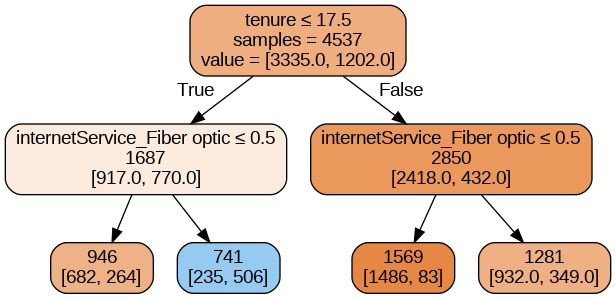

In [ ]:
plotDecisionTree(gridSearch.best_estimator_, feature_names=X_train.columns)

BLUE represents churn: We see that customers who have a tenure less than or equal to 17.5 months, and HAVE Fiber optic internet service are more likely to churn. Fiber Optic internet service needs to be properly analyzed and potentially reconfigured and repackaged. Likely the download/upload speed of the service is falling short of customers expectations.